<h1> 1. Exploring natality dataset </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using AI Platform Notebooks.
</ol>

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-01-eeabe3dadb32'
PROJECT = 'qwiklabs-gcp-01-eeabe3dadb32'
REGION = 'us-central1'

In [3]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [5]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [6]:
# Create SQL query using natality data after the year 2000
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [7]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.109908,False,25,1,38.0,1088037545023002395
1,7.588311,False,19,1,40.0,-2126480030009879160
2,4.812691,True,35,1,33.0,3408502330831153141
3,7.251004,True,30,2,38.0,6691862025345277042
4,6.206013,False,21,1,36.0,6392072535155213407


Let's write a query to find the unique values for each of the columns and the count of those values.
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [8]:
# Create function that finds the number of records and the average weight for each value of the chosen column
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

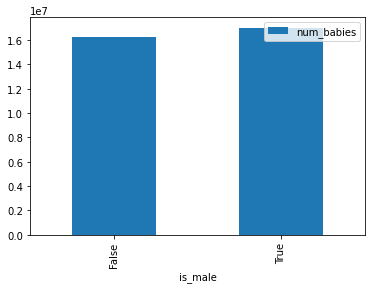

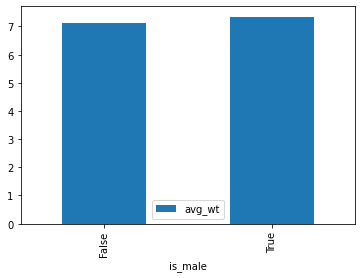

In [9]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

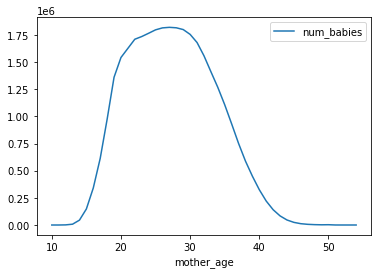

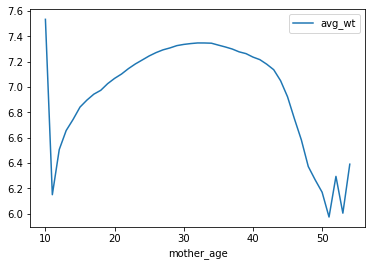

In [10]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

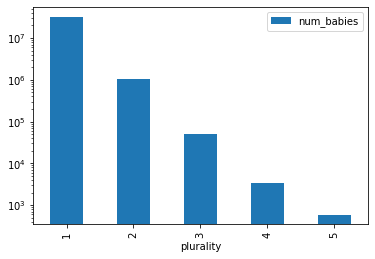

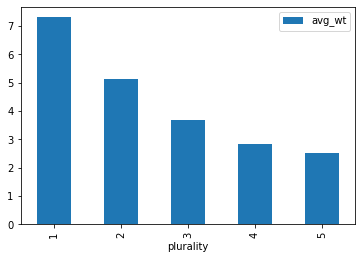

In [11]:
# Bar plot to see plurality(singleton, twins, etc.) with avg_wt linear and num_babies logarithmic
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', y='num_babies', logy=True, kind='bar');
df.plot(x='plurality', y='avg_wt', kind='bar');

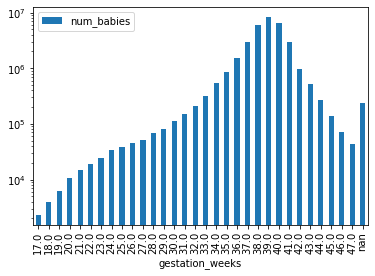

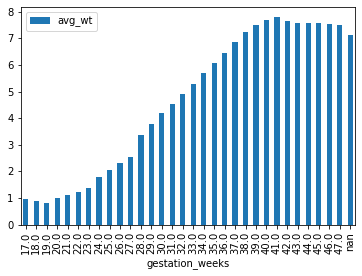

In [12]:
# Bar plot to see gestation_weeks with avg_wt linear and num_babies logarithmic
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the next notebook, I will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.